In [1]:
import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pecanpy

In [2]:
%matplotlib inline
plt.style.use("ggplot")

In [3]:
pd.__version__

'0.22.0'

In [4]:
# define user credentials
USER_NAME = ???
PASSWORD = ???

# define db server params
SCHEMA = ???
HOST = ???
PORT = ???
DB = ???

# create the engine that connects to the database...
engine = pecanpy.create_engine(USER_NAME, PASSWORD, HOST, PORT, DB)

In [5]:
with engine.connect() as con:
    metadata_df = pecanpy.read_metadata_table(con, schema=SCHEMA)

In [6]:
metadata_df.head()

,active_record,building_type,program_579,program_baseline,program_energy_internet_demo,program_lg_appliance,program_verizon,program_ccet_group,program_civita_group,city,...,refrigerator1,refrigerator2,security1,shed1,sprinkler1,utilityroom1,venthood1,waterheater1,waterheater2,winecooler1
dataid,,,,,,,,,,,,,,,,,,,,,
2836,False,Single-Family Home,False,False,True,False,False,None,None,Austin,...,False,False,False,False,False,False,False,False,False,False
2743,False,Single-Family Home,False,False,True,False,False,None,None,Austin,...,False,False,False,False,False,False,False,False,False,False
5323,False,Single-Family Home,False,True,True,False,False,None,None,Austin,...,False,False,False,False,False,False,False,False,False,False
8560,False,Single-Family Home,False,True,True,False,False,None,None,Austin,...,False,False,False,False,False,False,False,False,False,False
3313,False,Single-Family Home,False,True,True,False,False,None,None,Austin,...,False,False,False,False,False,False,False,False,False,False


In [16]:
time = datetime.datetime.now()
seed = time.hour * 10000 + time.minute * 100 + time.second
prng = np.random.RandomState(seed)
with_egauge_data = metadata_df[metadata_df.egauge_min_time.notnull()]
random_household = with_egauge_data.sample(n=1, random_state=prng)

In [17]:
# how much available data possibly exists?
start_time = random_household.iloc[0].egauge_min_time
end_time = random_household.iloc[0].egauge_max_time
time_delta = end_time - start_time

In [18]:
time_delta

Timedelta('455 days 08:59:00')

In [19]:
with engine.connect() as con:

    # extract the required parameters
    dataid = random_household.iloc[0].name
    start_time = random_household.iloc[0].egauge_min_time
    end_time = random_household.iloc[0].egauge_max_time

    # pull down data for different aggregations
    minutes_df = pecanpy.read_electricity_egauge_query(con, SCHEMA, dataid, start_time, end_time, "all", 'T')
    qtr_hour_df = pecanpy.read_electricity_egauge_query(con, SCHEMA, dataid, start_time, end_time, "all", "15T")
    hours_df = pecanpy.read_electricity_egauge_query(con, SCHEMA, dataid, start_time, end_time, "all", 'H')

## Minutes data

In [20]:
minutes_df.shape

(655739, 68)

In [21]:
minutes_df.head()

,dataid,use,air1,air2,air3,airwindowunit1,aquarium1,bathroom1,bathroom2,bedroom1,...,refrigerator1,refrigerator2,security1,shed1,sprinkler1,utilityroom1,venthood1,waterheater1,waterheater2,winecooler1
localminute,,,,,,,,,,,,,,,,,,,,,
2014-01-15 18:00:00-06:00,5944,0.058,None,None,None,None,None,0.0,None,None,...,0.0,None,None,None,None,None,None,None,None,None
2014-01-15 18:01:00-06:00,5944,0.058,None,None,None,None,None,0.0,None,None,...,0.0,None,None,None,None,None,None,None,None,None
2014-01-15 18:02:00-06:00,5944,0.058,None,None,None,None,None,0.0,None,None,...,0.0,None,None,None,None,None,None,None,None,None
2014-01-15 18:03:00-06:00,5944,0.058,None,None,None,None,None,0.0,None,None,...,0.0,None,None,None,None,None,None,None,None,None
2014-01-15 18:04:00-06:00,5944,0.100,None,None,None,None,None,0.0,None,None,...,0.0,None,None,None,None,None,None,None,None,None


In [22]:
minutes_df.tail()

,dataid,use,air1,air2,air3,airwindowunit1,aquarium1,bathroom1,bathroom2,bedroom1,...,refrigerator1,refrigerator2,security1,shed1,sprinkler1,utilityroom1,venthood1,waterheater1,waterheater2,winecooler1
localminute,,,,,,,,,,,,,,,,,,,,,
2015-04-16 03:54:00-05:00,5944,0.063,None,None,None,None,None,0.0,None,None,...,0.0,None,None,None,None,None,None,None,None,None
2015-04-16 03:55:00-05:00,5944,0.063,None,None,None,None,None,0.0,None,None,...,0.0,None,None,None,None,None,None,None,None,None
2015-04-16 03:56:00-05:00,5944,0.062,None,None,None,None,None,0.0,None,None,...,0.0,None,None,None,None,None,None,None,None,None
2015-04-16 03:57:00-05:00,5944,0.063,None,None,None,None,None,0.0,None,None,...,0.0,None,None,None,None,None,None,None,None,None
2015-04-16 03:58:00-05:00,5944,0.062,None,None,None,None,None,0.0,None,None,...,0.0,None,None,None,None,None,None,None,None,None


In [23]:
# if gen is not null, then household is a prosumer!
minutes_df[["grid", "use", "gen"]].head()

,grid,use,gen
localminute,,,
2014-01-15 18:00:00-06:00,0.058,0.058,None
2014-01-15 18:01:00-06:00,0.058,0.058,None
2014-01-15 18:02:00-06:00,0.058,0.058,None
2014-01-15 18:03:00-06:00,0.058,0.058,None
2014-01-15 18:04:00-06:00,0.100,0.100,None


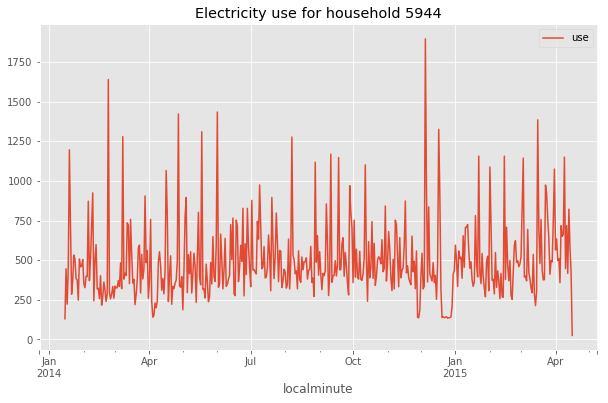

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# plot total daily electricity usage
minutes_df.use.resample("D").sum().plot(ax=ax, label="use")
ax.set_title("Electricity use for household {}".format(dataid))
ax.legend()
plt.show()

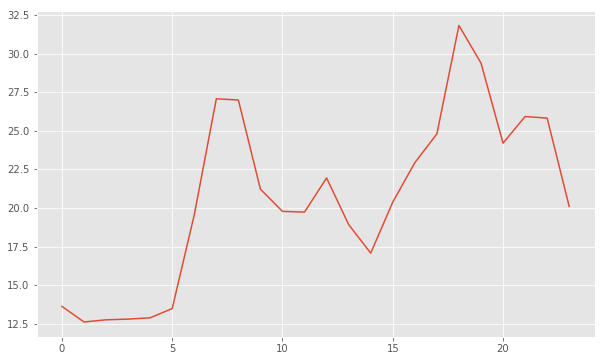

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
hourly_load_curves = (minutes_df.resample("H")
                                .sum()
                                .groupby(lambda timestamp: timestamp.hour)
                                .mean())
hourly_load_curves.use.plot(ax=ax);

## 15-minute data

In [26]:
qtr_hour_df.head()

,dataid,use,air1,air2,air3,airwindowunit1,aquarium1,bathroom1,bathroom2,bedroom1,...,refrigerator1,refrigerator2,security1,shed1,sprinkler1,utilityroom1,venthood1,waterheater1,waterheater2,winecooler1
local_15min,,,,,,,,,,,,,,,,,,,,,
2014-01-15 12:00:00-06:00,5944,0.118333,None,None,None,None,None,0.0,None,None,...,0.000467,None,None,None,None,None,None,None,None,None
2014-01-15 12:15:00-06:00,5944,0.216667,None,None,None,None,None,0.0,None,None,...,0.089533,None,None,None,None,None,None,None,None,None
2014-01-15 12:30:00-06:00,5944,0.104000,None,None,None,None,None,0.0,None,None,...,0.000000,None,None,None,None,None,None,None,None,None
2014-01-15 12:45:00-06:00,5944,0.186933,None,None,None,None,None,0.0,None,None,...,0.035867,None,None,None,None,None,None,None,None,None
2014-01-15 13:00:00-06:00,5944,0.205133,None,None,None,None,None,0.0,None,None,...,0.057333,None,None,None,None,None,None,None,None,None


In [27]:
qtr_hour_df.tail()

,dataid,use,air1,air2,air3,airwindowunit1,aquarium1,bathroom1,bathroom2,bedroom1,...,refrigerator1,refrigerator2,security1,shed1,sprinkler1,utilityroom1,venthood1,waterheater1,waterheater2,winecooler1
local_15min,,,,,,,,,,,,,,,,,,,,,
2015-04-15 21:45:00-05:00,5944,0.062800,None,None,None,None,None,0.0,None,None,...,0.000000,None,None,None,None,None,None,None,None,None
2015-04-15 22:00:00-05:00,5944,0.082667,None,None,None,None,None,0.0,None,None,...,0.020533,None,None,None,None,None,None,None,None,None
2015-04-15 22:15:00-05:00,5944,0.158200,None,None,None,None,None,0.0,None,None,...,0.097667,None,None,None,None,None,None,None,None,None
2015-04-15 22:30:00-05:00,5944,0.113333,None,None,None,None,None,0.0,None,None,...,0.051733,None,None,None,None,None,None,None,None,None
2015-04-15 22:45:00-05:00,5944,0.062467,None,None,None,None,None,0.0,None,None,...,0.000000,None,None,None,None,None,None,None,None,None


In [28]:
# can recover the 15-minute data ay aggregating the minutes data!
minutes_df.resample("15T").mean().tail()

,dataid,use,bathroom1,clotheswasher1,dishwasher1,disposal1,drye1,furnace1,grid,kitchenapp1,kitchenapp2,microwave1,refrigerator1
localminute,,,,,,,,,,,,,
2015-04-16 02:45:00-05:00,5944,0.062800,0.0,0.0,0.0,0.0,0.0,0.007,0.062800,0.0,0.0,0.008000,0.000000
2015-04-16 03:00:00-05:00,5944,0.082667,0.0,0.0,0.0,0.0,0.0,0.007,0.082667,0.0,0.0,0.008067,0.020533
2015-04-16 03:15:00-05:00,5944,0.158200,0.0,0.0,0.0,0.0,0.0,0.007,0.158200,0.0,0.0,0.008000,0.097667
2015-04-16 03:30:00-05:00,5944,0.113333,0.0,0.0,0.0,0.0,0.0,0.007,0.113333,0.0,0.0,0.008000,0.051733
2015-04-16 03:45:00-05:00,5944,0.062429,0.0,0.0,0.0,0.0,0.0,0.007,0.062429,0.0,0.0,0.008000,0.000000


## Hours data

In [29]:
hours_df.head()

,dataid,use,air1,air2,air3,airwindowunit1,aquarium1,bathroom1,bathroom2,bedroom1,...,refrigerator1,refrigerator2,security1,shed1,sprinkler1,utilityroom1,venthood1,waterheater1,waterheater2,winecooler1
localhour,,,,,,,,,,,,,,,,,,,,,
2014-01-15 18:00:00-06:00,5944,0.156483,None,None,None,None,None,0.0,None,None,...,0.031467,None,None,None,None,None,None,None,None,None
2014-01-15 19:00:00-06:00,5944,0.250033,None,None,None,None,None,0.0,None,None,...,0.038050,None,None,None,None,None,None,None,None,None
2014-01-15 20:00:00-06:00,5944,0.385183,None,None,None,None,None,0.0,None,None,...,0.029850,None,None,None,None,None,None,None,None,None
2014-01-15 21:00:00-06:00,5944,0.287483,None,None,None,None,None,0.0,None,None,...,0.048300,None,None,None,None,None,None,None,None,None
2014-01-15 22:00:00-06:00,5944,0.394267,None,None,None,None,None,0.0,None,None,...,0.030217,None,None,None,None,None,None,None,None,None


In [30]:
hours_df.tail()

,dataid,use,air1,air2,air3,airwindowunit1,aquarium1,bathroom1,bathroom2,bedroom1,...,refrigerator1,refrigerator2,security1,shed1,sprinkler1,utilityroom1,venthood1,waterheater1,waterheater2,winecooler1
localhour,,,,,,,,,,,,,,,,,,,,,
2015-04-15 23:00:00-05:00,5944,0.138183,None,None,None,None,None,0.0,None,None,...,0.044517,None,None,None,None,None,None,None,None,None
2015-04-16 00:00:00-05:00,5944,0.104750,None,None,None,None,None,0.0,None,None,...,0.043283,None,None,None,None,None,None,None,None,None
2015-04-16 01:00:00-05:00,5944,0.106183,None,None,None,None,None,0.0,None,None,...,0.044767,None,None,None,None,None,None,None,None,None
2015-04-16 02:00:00-05:00,5944,0.105717,None,None,None,None,None,0.0,None,None,...,0.043850,None,None,None,None,None,None,None,None,None
2015-04-16 03:00:00-05:00,5944,0.104167,None,None,None,None,None,0.0,None,None,...,0.042483,None,None,None,None,None,None,None,None,None


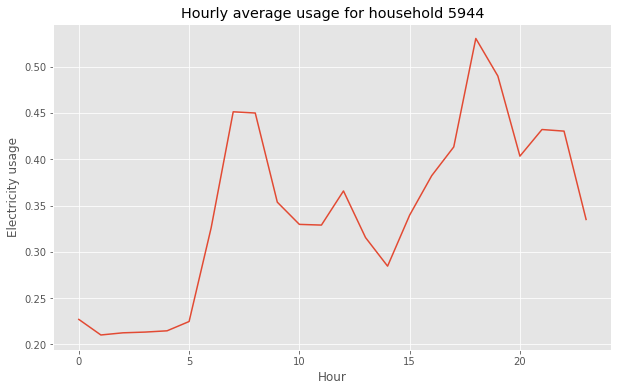

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.set_xlabel("Hour")
ax.set_ylabel("Electricity usage")
ax.set_title("Hourly average usage for household {}".format(dataid))
hours_df.use.groupby(lambda idx: idx.hour).mean().plot(ax=ax);
